# Ethereum Fraud Detection

This dataset contains rows of known fraud and valid transactions made over the Ethereum network.

### Summary of Results

80-20 train test split

train set is resampled, cross validated and used for modelling

test set is for evaluating model performance

Adaboost (with Decision Tree base estimator) 10-fold cross validated predictions on SMOTEENN resampled train set
 - Accuracy : 0.99885
 - Precision: 0.99885
 - Recall   : 0.99884
 - F-score  : 0.99885
 - ROC AUC  : 0.99884

Adaboost (with Decision Tree base estimator) predictions on test set
 - Accuracy : 0.99445
 - Precision: 0.99342
 - Recall   : 0.98373
 - F-score  : 0.98851
 - ROC AUC  : 0.98373
#### Precision >> Recall which is what we want for fraud detection purposes

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, auc, roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_predict, StratifiedKFold, RandomizedSearchCV, GridSearchCV, train_test_split

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from imblearn.combine import SMOTEENN

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [2]:
raw = pd.read_csv("/Users/kaihayden/Downloads/transaction_dataset.csv")

In [3]:
pd.concat([raw.isna().sum(),raw.nunique()],axis=1).rename(columns = {0:'Nulls',1:'Uniques'})

,Nulls,Uniques
Unnamed: 0,0,9841
Index,0,4729
Address,0,9816
FLAG,0,2
Avg min between sent tnx,0,5013
Avg min between received tnx,0,6223
Time Diff between first and last (Mins),0,7810
Sent tnx,0,641
Received Tnx,0,727
Number of Created Contracts,0,20


In [4]:
df = raw.drop(['Unnamed: 0', 'Index', 'Address',' ERC20 avg time between sent tnx',' ERC20 avg time between rec tnx',
               ' ERC20 avg time between rec 2 tnx',' ERC20 avg time between contract tnx',' ERC20 min val sent contract',
               ' ERC20 max val sent contract',' ERC20 avg val sent contract',
               ' ERC20 uniq sent addr.1',' Total ERC20 tnxs'], axis = 1)

In [5]:
df.columns

Index(['FLAG', 'Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'Unique Received From Addresses',
       'Unique Sent To Addresses', 'min value received', 'max value received ',
       'avg val received', 'min val sent', 'max val sent', 'avg val sent',
       'min value sent to contract', 'max val sent to contract',
       'avg value sent to contract',
       'total transactions (including tnx to create contract',
       'total Ether sent', 'total ether received',
       'total ether sent contracts', 'total ether balance',
       ' ERC20 total Ether received', ' ERC20 total ether sent',
       ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr',
       ' ERC20 uniq rec addr', ' ERC20 uniq rec contract addr',
       ' ERC20 min val rec', ' ERC20 max val rec', ' ERC20 avg val rec',
       ' ERC20 min val sent', ' ERC20 max val sent', ' ERC20 avg val sent'

In [6]:
df.rename(columns={'FLAG': 'is_fraud',
                   'Avg min between sent tnx': 'avg_time_between_sends',
                   'Avg min between received tnx': 'avg_time_between_recvs',
                   'Time Diff between first and last (Mins)': 'time_since_first_transaction',
                   'Sent tnx': 'sent_transactions',
                   'Received Tnx': 'recv_transactions',
                   'Number of Created Contracts': 'num_created_contracts',
                   'Unique Received From Addresses': 'total_addr_recv',
                   'Unique Sent To Addresses': 'total_addr_sent',
                   'min value received': 'min_val_recv',
                   'max value received ': 'max_val_recv',
                   'avg val received': 'avg_val_recv',
                   'min val sent': 'min_val_sent',
                   'max val sent': 'max_val_sent',
                   'avg val sent': 'avg_val_sent',
                   'min value sent to contract': 'min_val_sent_contracts',
                   'max val sent to contract': 'max_val_sent_contracts',
                   'avg value sent to contract': 'avg_val_sent_contracts',
                   'total transactions (including tnx to create contract': 'total_transactions',
                   'total Ether sent': 'total_ether_sent',
                   'total ether received': 'total_ether_recv',
                   'total ether sent contracts': 'total_ether_sent_contracts',
                   'total ether balance': 'total_ether_balance',
                   ' ERC20 total Ether received': 'erc_ether_recv',
                   ' ERC20 total ether sent': 'erc_ether_sent',
                   ' ERC20 total Ether sent contract': 'erc_ether_sent_contracts',
                   ' ERC20 uniq sent addr': 'erc_total_addr_sent',
                   ' ERC20 uniq rec addr': 'erc_total_addr_recv',
                   ' ERC20 uniq rec contract addr': 'erc_total_addr_sent_contracts',
                   ' ERC20 min val rec': 'erc_min_val_recv',
                   ' ERC20 max val rec': 'erc_max_val_recv',
                   ' ERC20 avg val rec': 'erc_avg_val_recv',
                   ' ERC20 min val sent': 'erc_min_val_sent',
                   ' ERC20 max val sent': 'erc_max_val_sent',
                   ' ERC20 avg val sent': 'erc_avg_val_sent',
                   ' ERC20 uniq sent token name': 'erc_unique_tokens_sent',
                   ' ERC20 uniq rec token name': 'erc_unique_tokens_recv',
                   ' ERC20 most sent token type': 'erc_most_sent_token',
                   ' ERC20_most_rec_token_type': 'erc_most_recv_token'}, inplace=True)

In [7]:
def compare_plot(df, target, var, limit='auto', bins='auto', suplab = '', ylab='', xlab=''):

    if limit is None:
        limit = df[var].max()
    if suplab == '':
        suplab = var
    if ylab == '':
        ylab = target
    if xlab == '':
        xlab = var
    if limit == 'auto':
        limit = df[var].quantile(0.98, 'lower')
    if bins == 'auto':
        bins = math.ceil(min(50, len(df[(df[var]<=limit)][var].unique())))

    fig, ax = plt.subplots(1,3,figsize=(20,5))

    ax[0].hist(df[df[var]<=limit][var], bins=bins)
    ax[1].hist(df[(df[target]==0) & (df[var]<=limit)][var], bins=bins)
    ax[2].hist(df[(df[target]==1) & (df[var]<=limit)][var], bins=bins)

    fig.suptitle(suplab, fontweight='bold', fontsize=16)
    
    ax[0].set_title('Overall')
    ax[1].set_title('Non Fraud')
    ax[2].set_title('Fraud')
    
    ax[0].set_ylabel(ylab)
    ax[0].set_xlabel(xlab)
    ax[1].set_xlabel(xlab)
    ax[2].set_xlabel(xlab)

    plt.show()

## EDA

Split the dataset roughly into 3rds

In [8]:
df_first = df.iloc[:,0:12] 

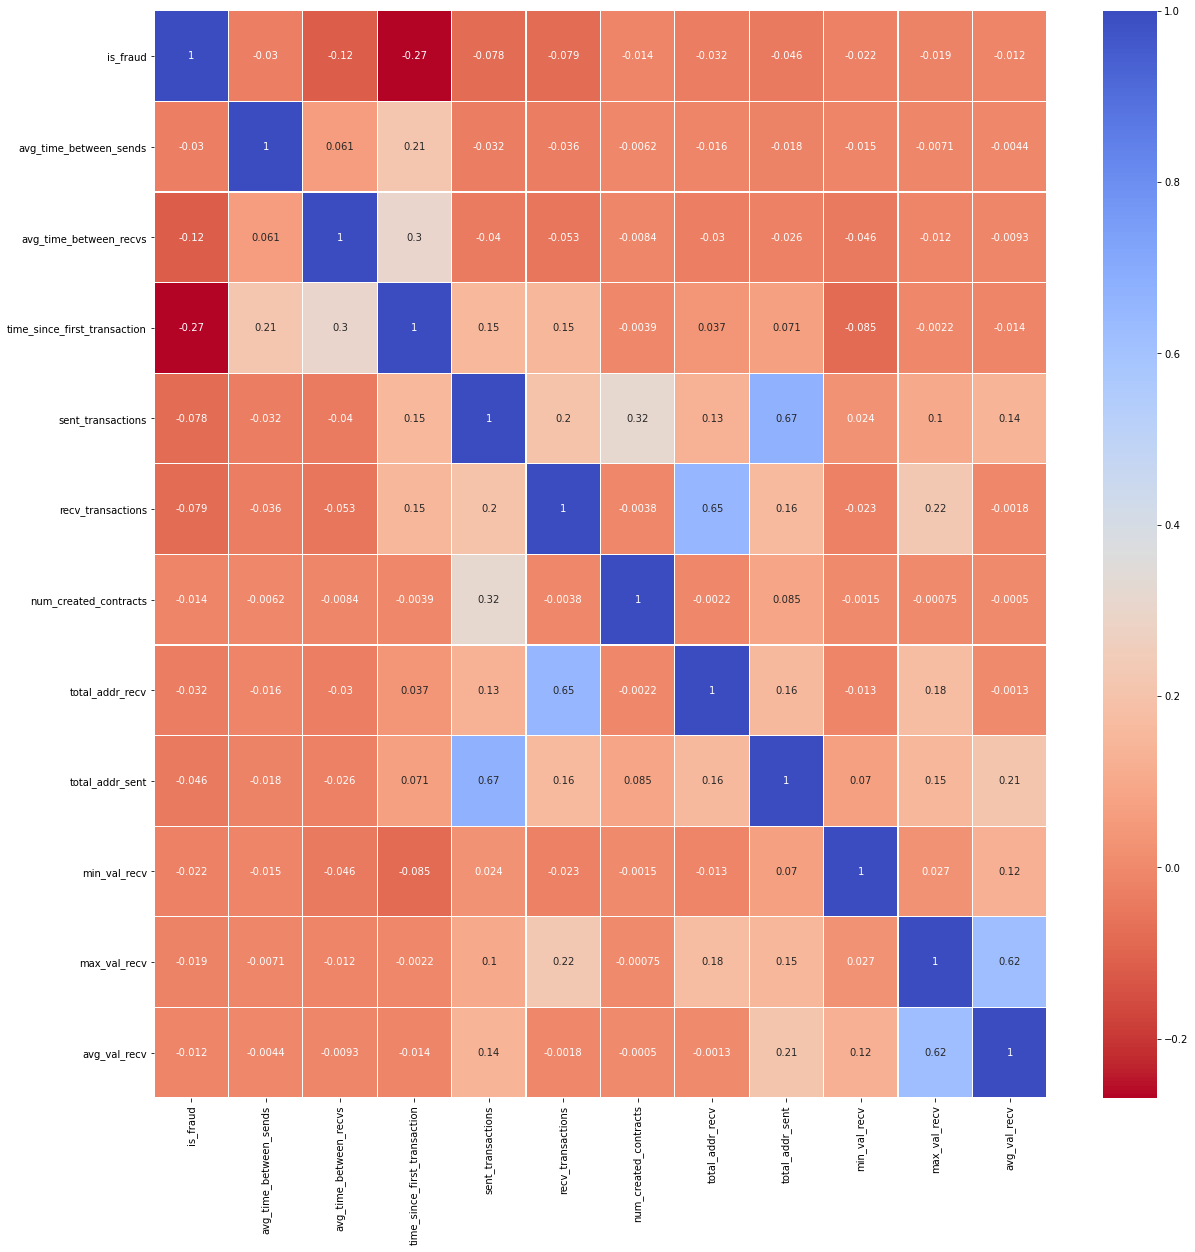

In [9]:
sns.heatmap(df_first.corr(),annot=True,cmap='coolwarm_r',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

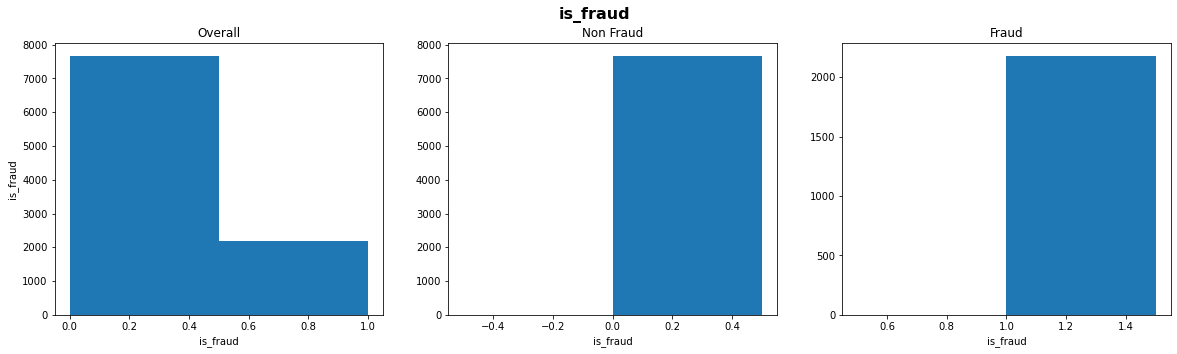

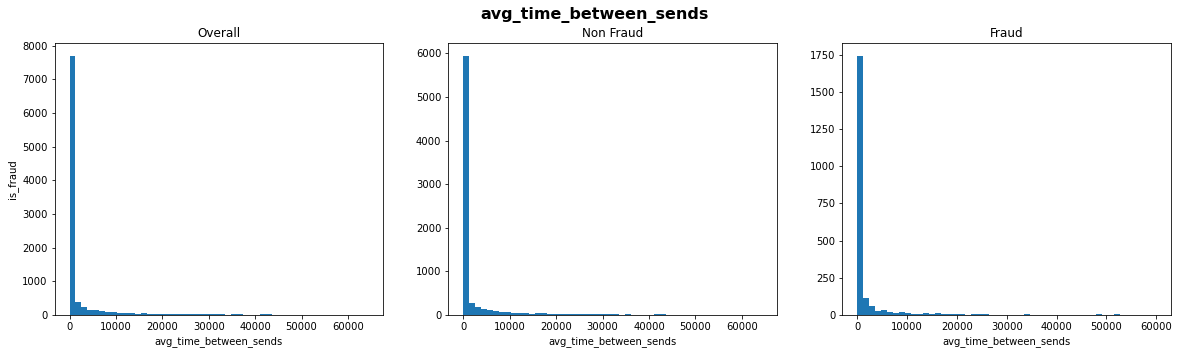

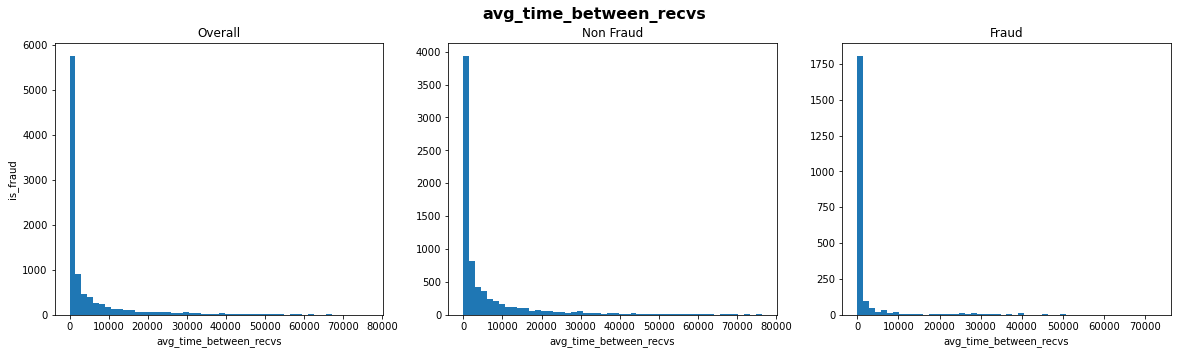

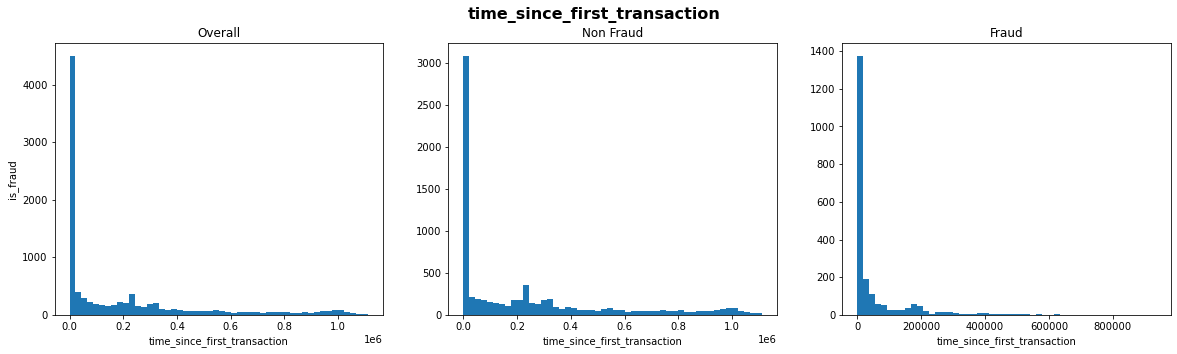

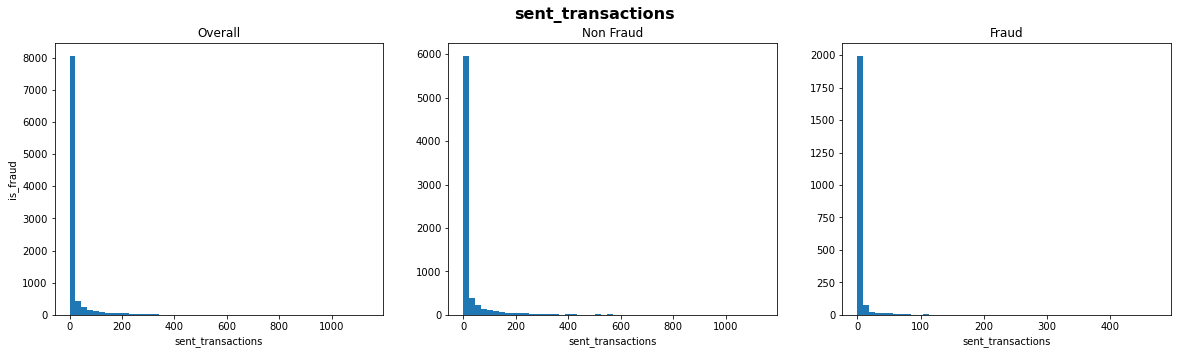

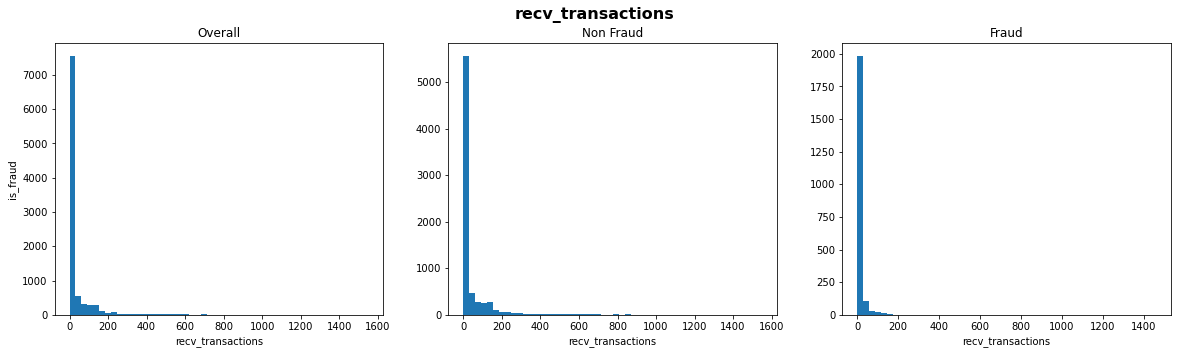

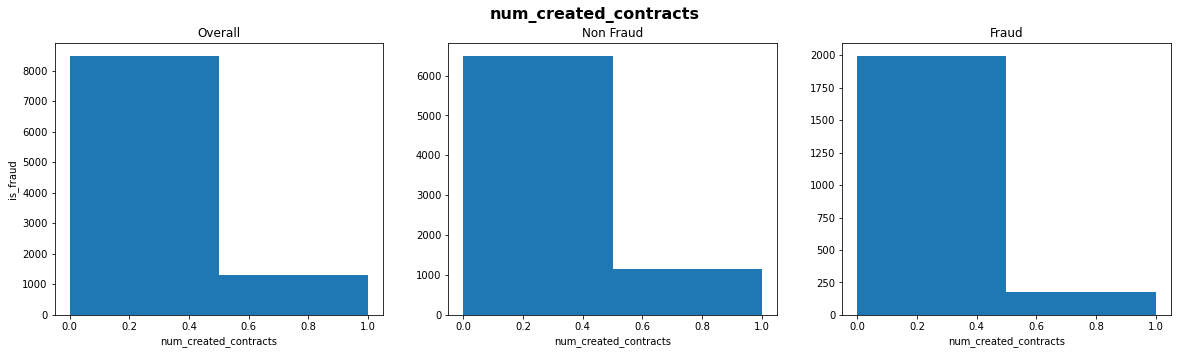

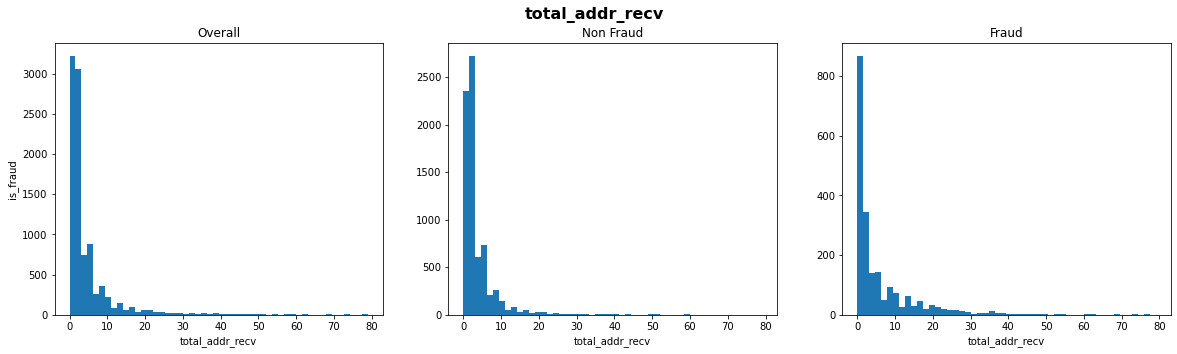

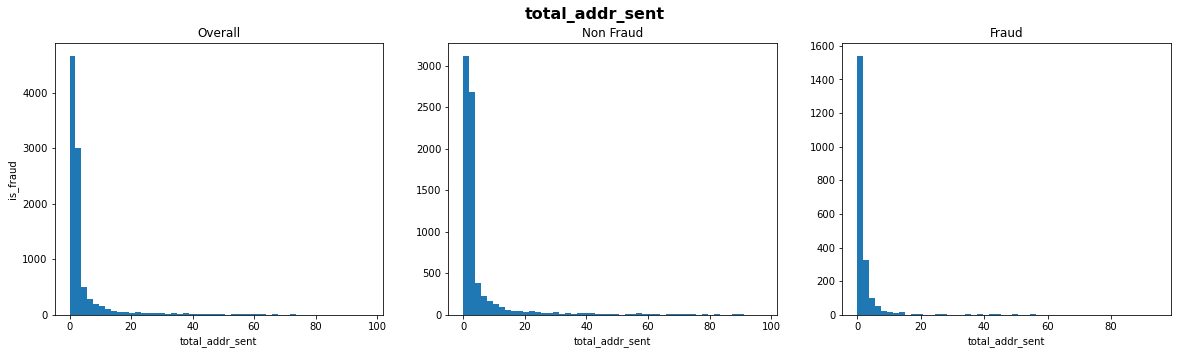

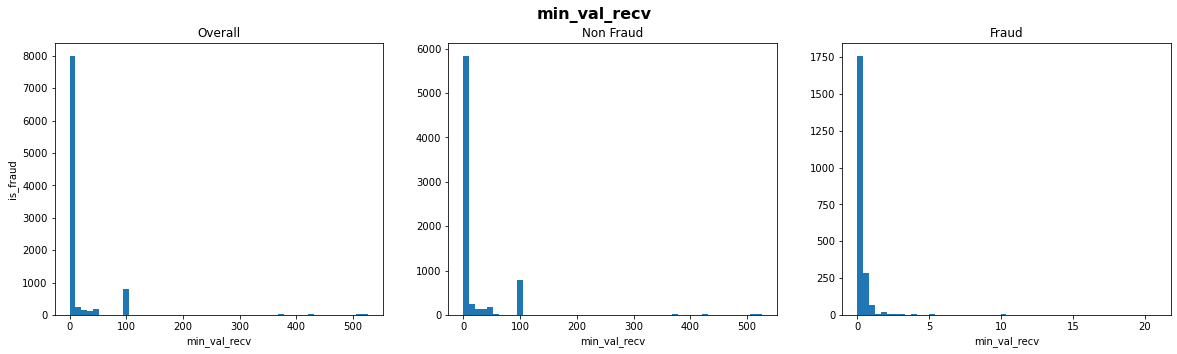

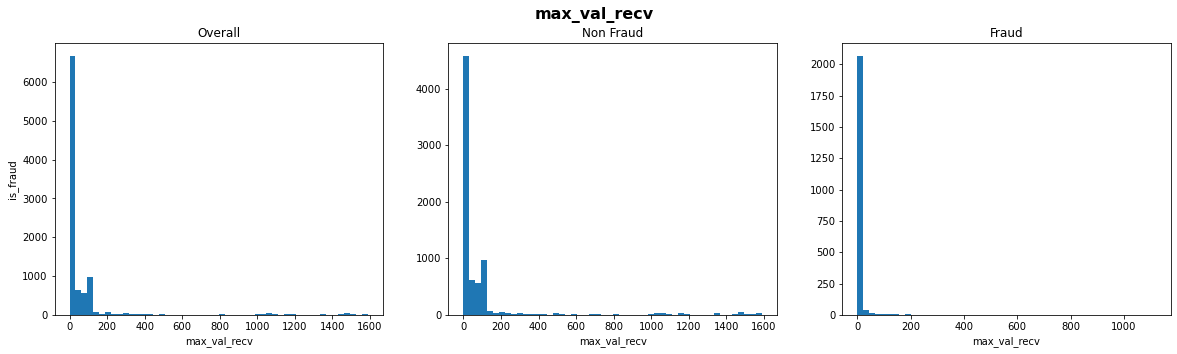

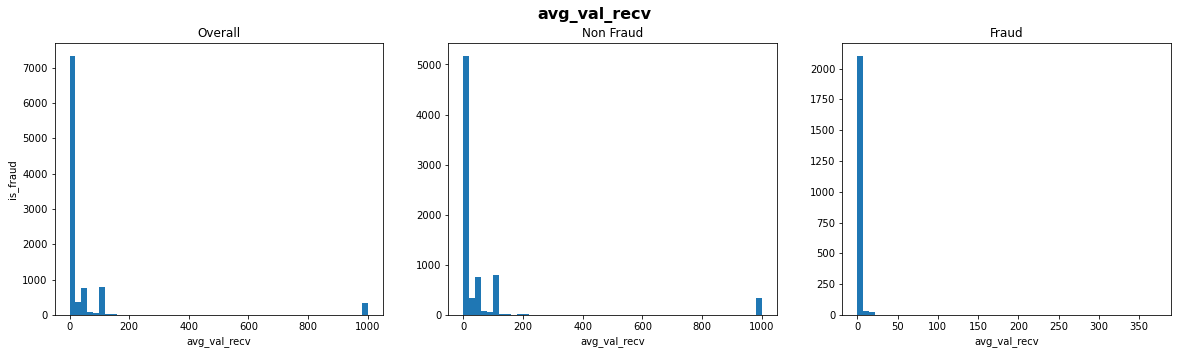

In [10]:
cols = list(df_first.columns)
for i in cols:
    compare_plot(df_first, 'is_fraud', i)

In [11]:
df_mid = df.iloc[:,[0,12,13,14,15,16,17,18,19,20,21,22]]

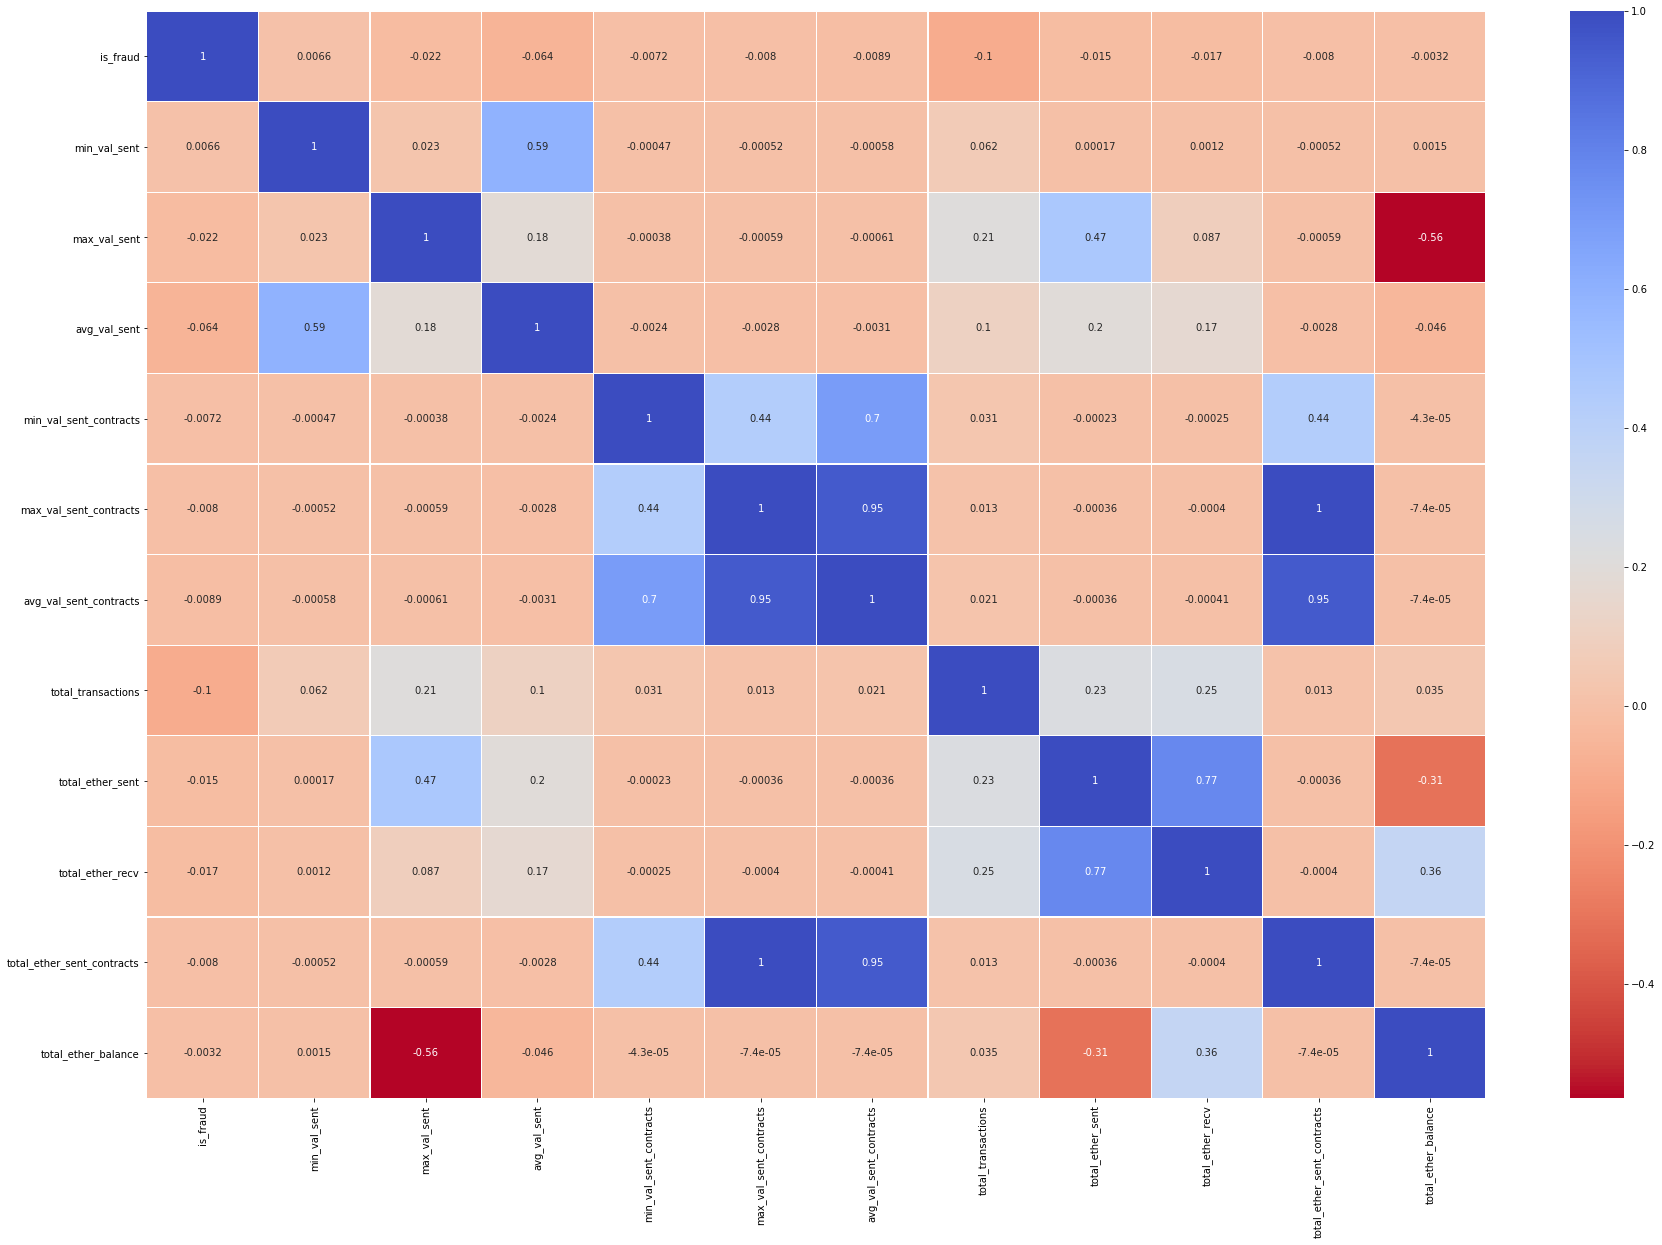

In [12]:
sns.heatmap(df_mid.corr(),annot=True,cmap='coolwarm_r',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(30,20)
plt.show()

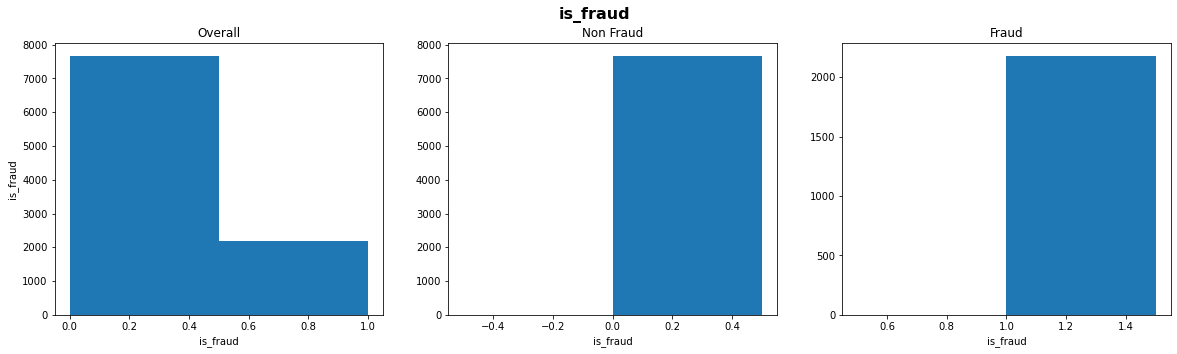

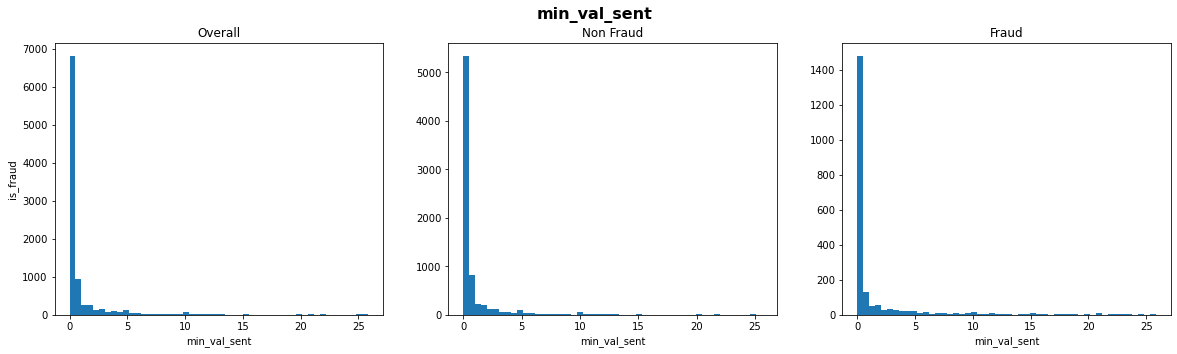

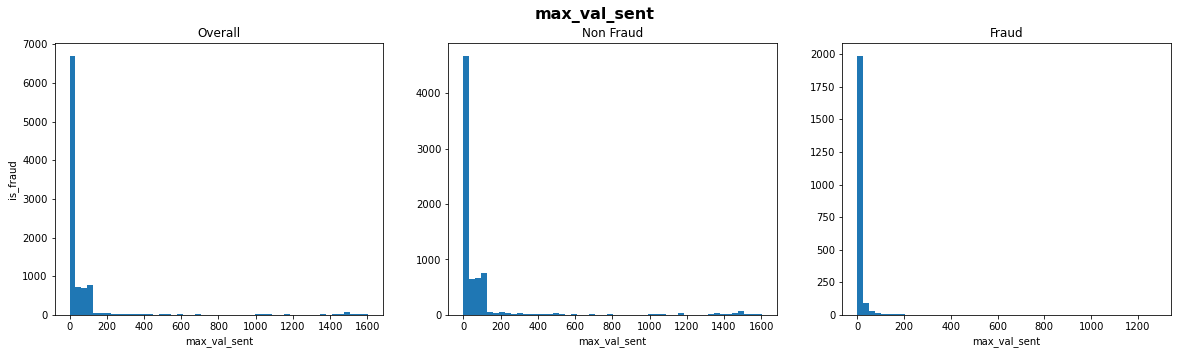

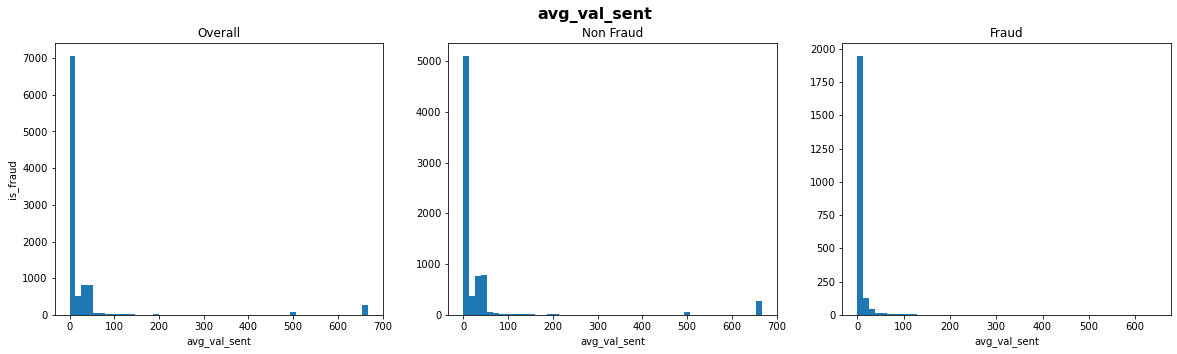

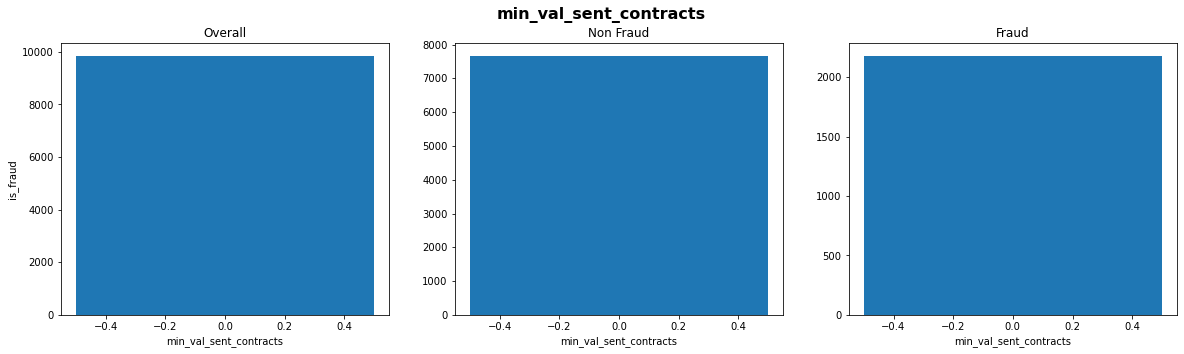

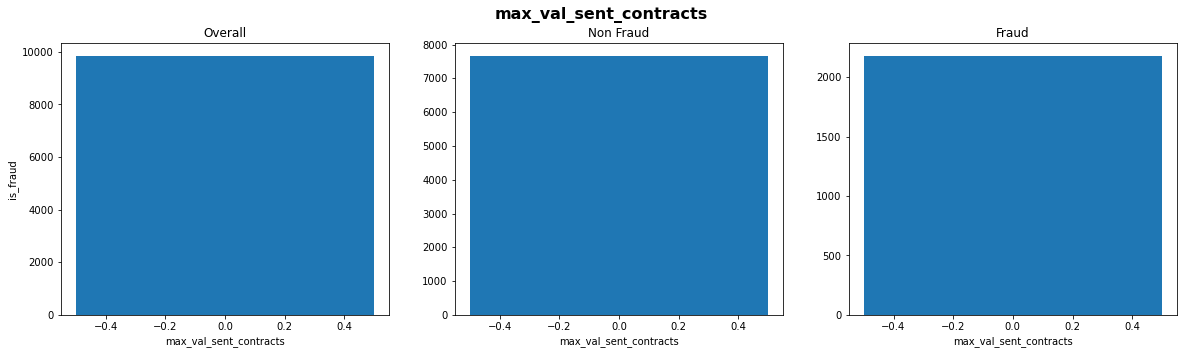

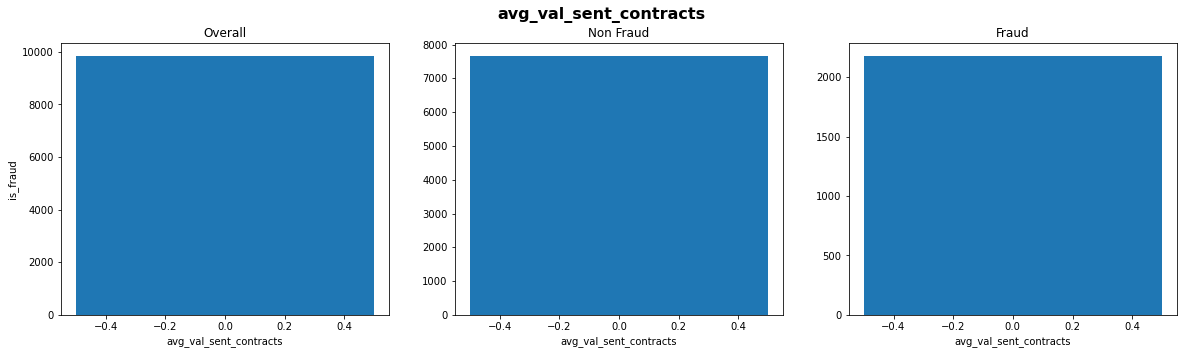

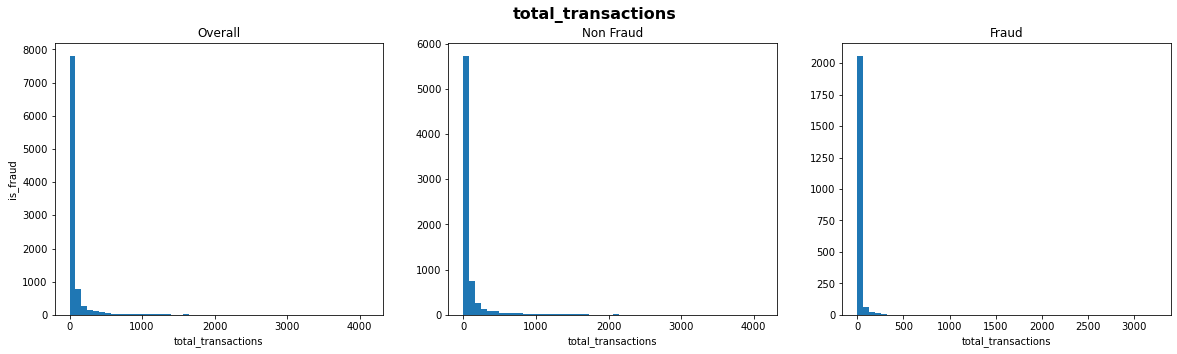

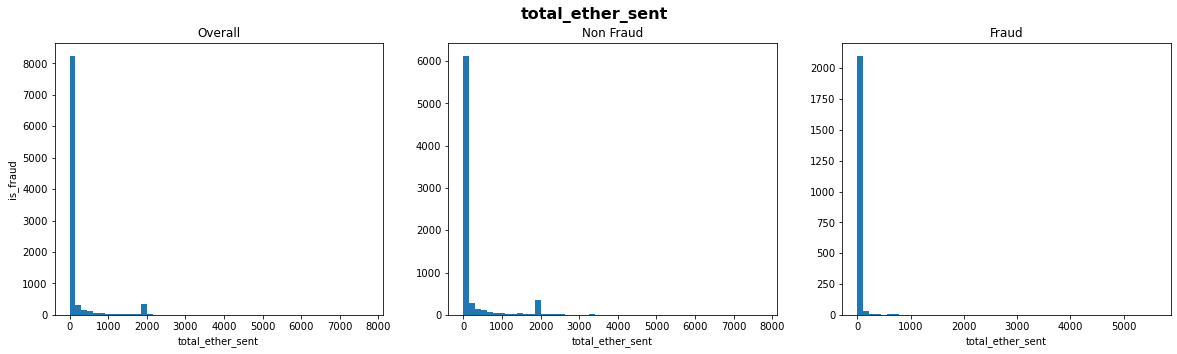

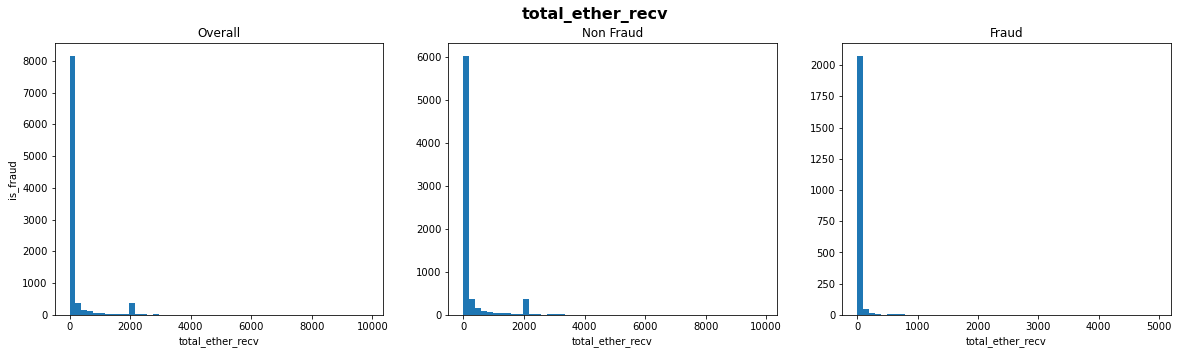

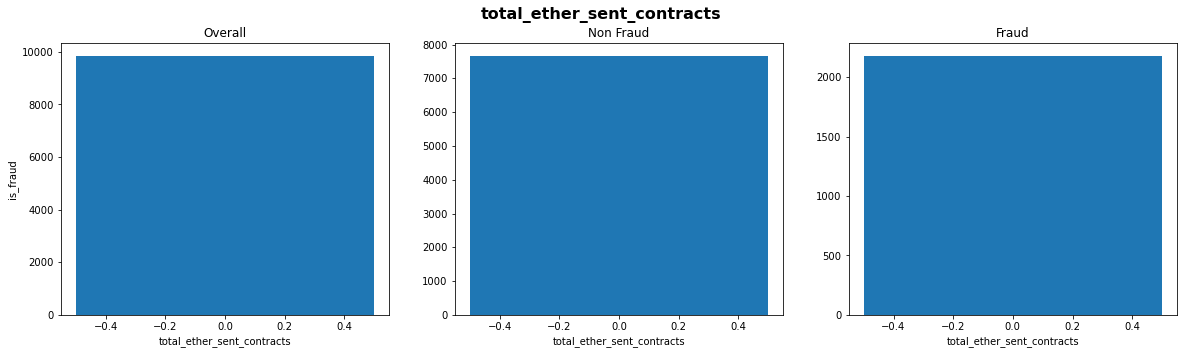

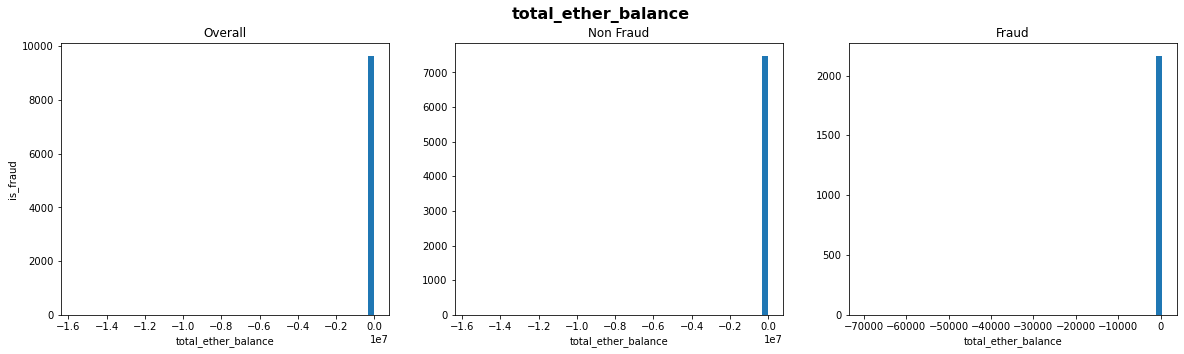

In [13]:
cols = list(df_mid.columns)
for i in cols:
    compare_plot(df_mid, 'is_fraud', i)

In [14]:
erc = [col for col in df.columns if 'erc' in col]
erc.append('is_fraud')
df_erc = df[erc]

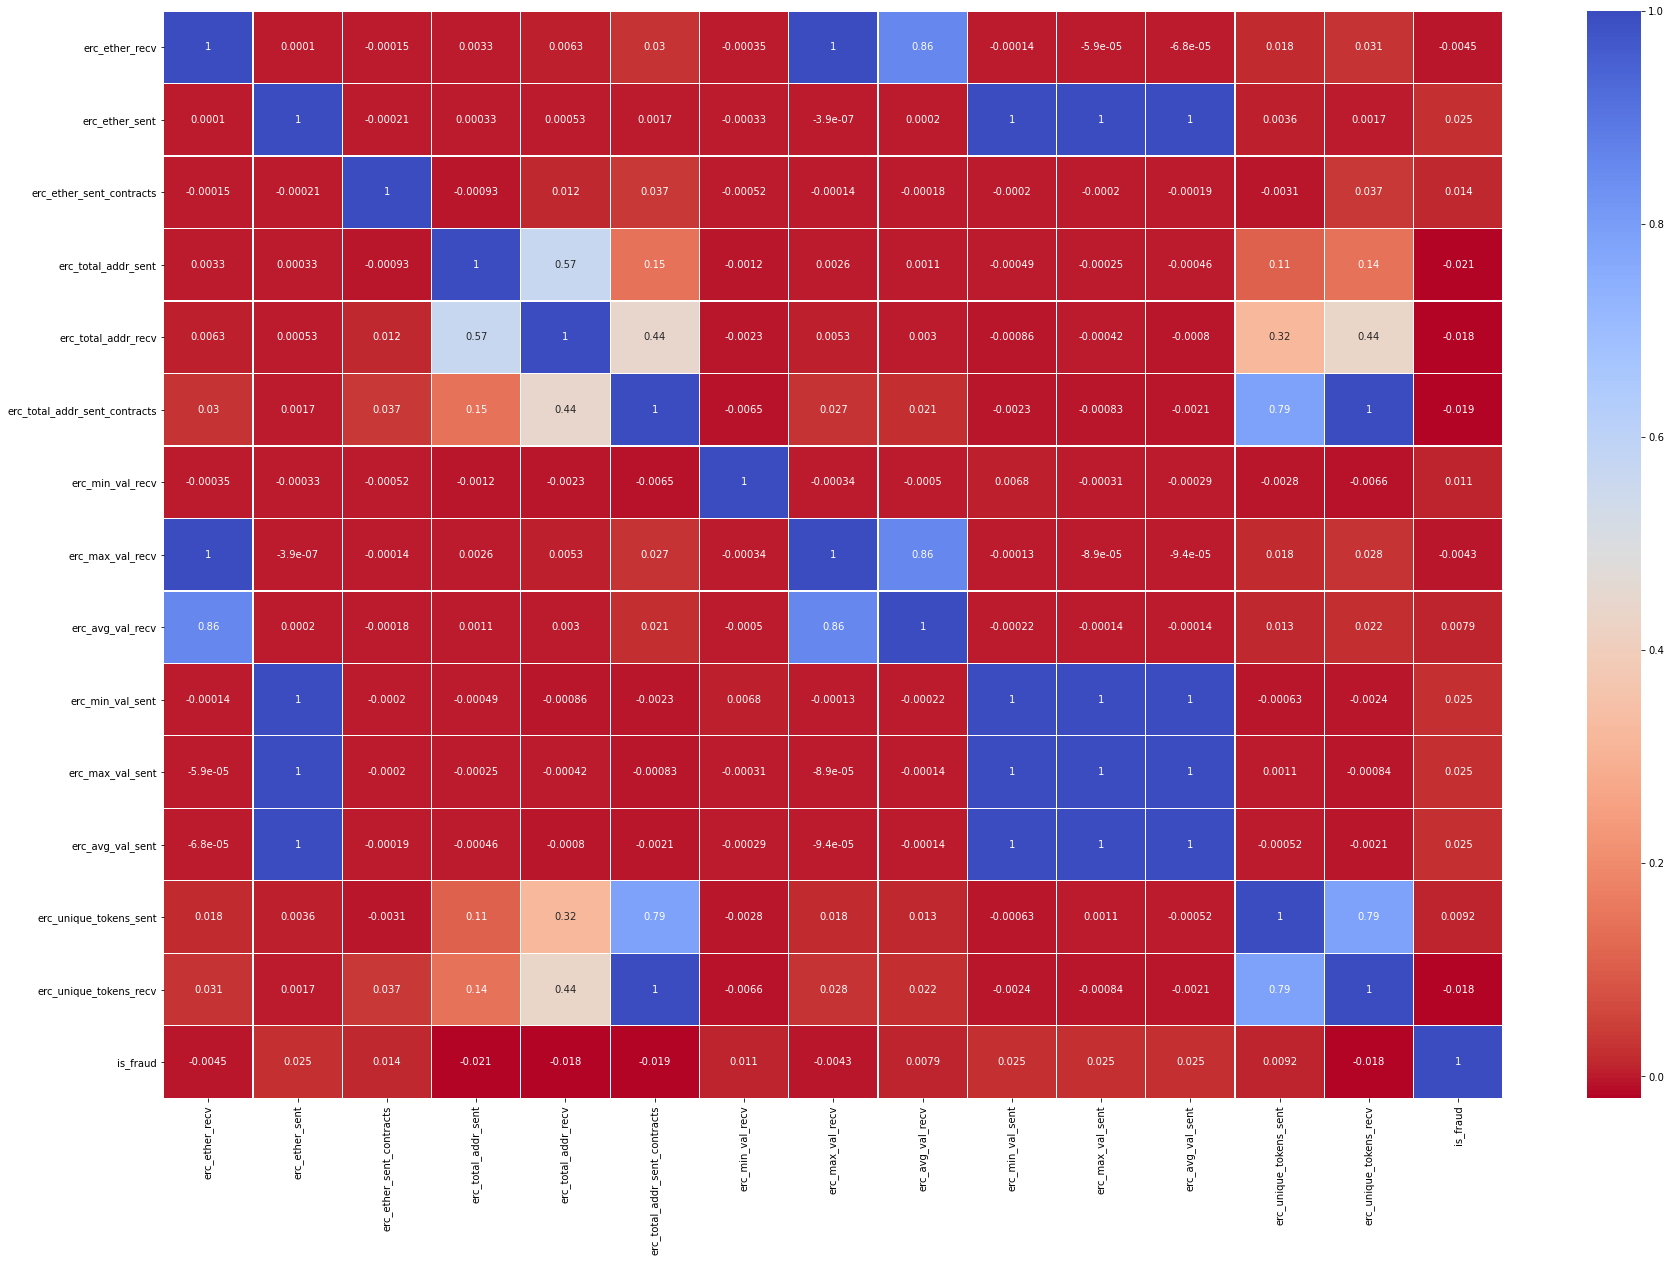

In [15]:
sns.heatmap(df_erc.corr(),annot=True,cmap='coolwarm_r',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(30,20)
plt.show()

In [16]:
cols = list(df_erc.columns)
cols.pop();

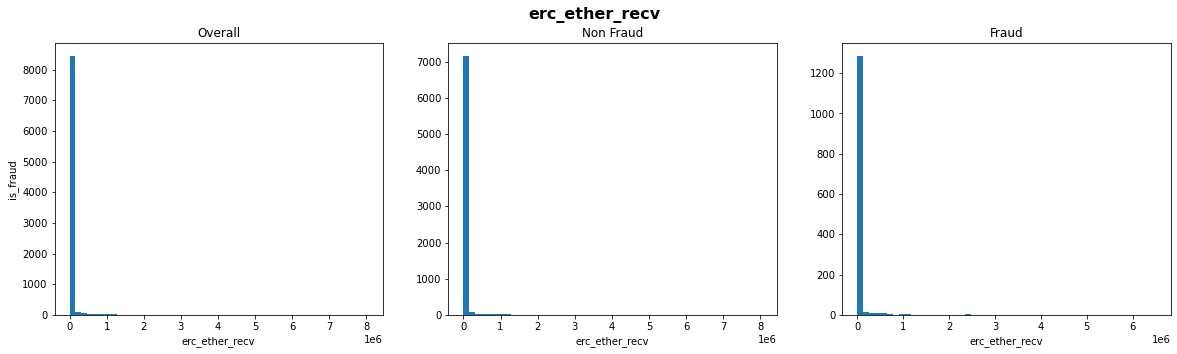

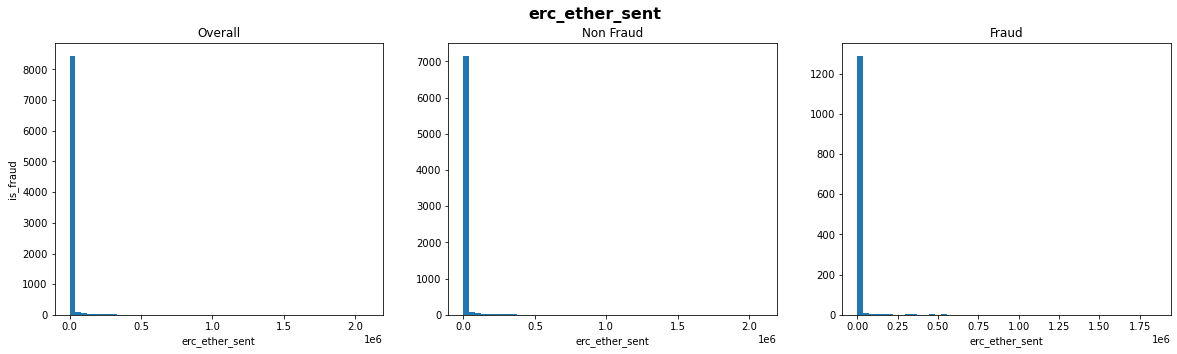

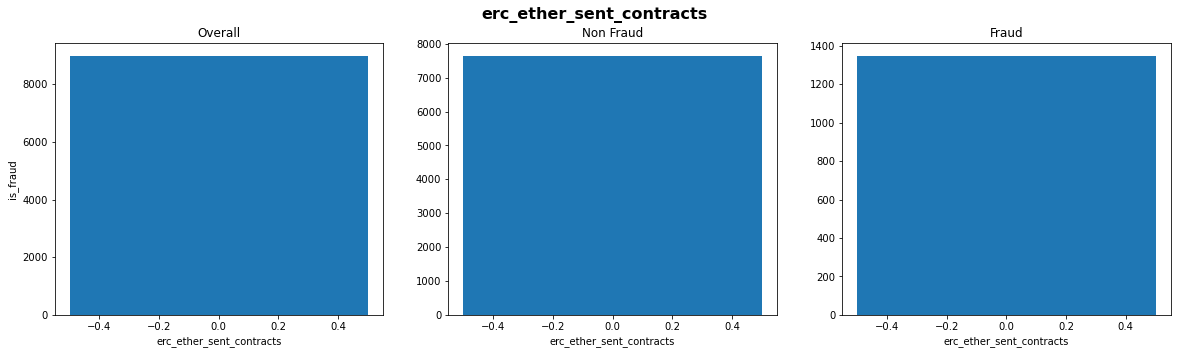

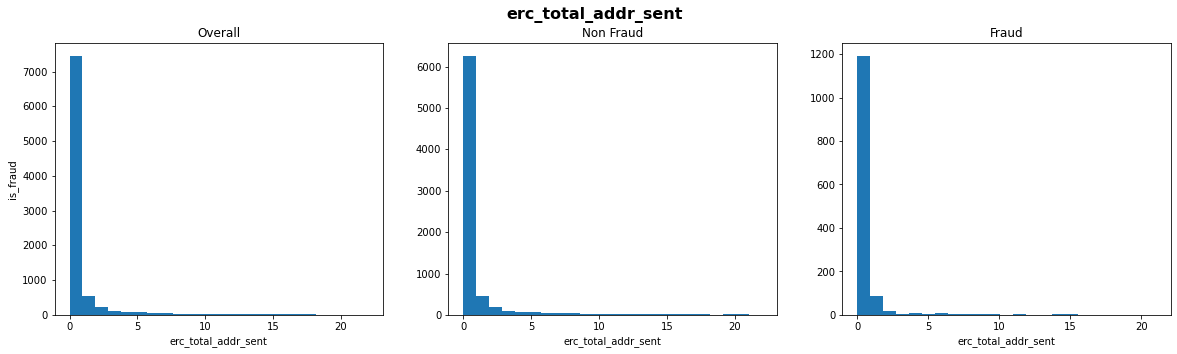

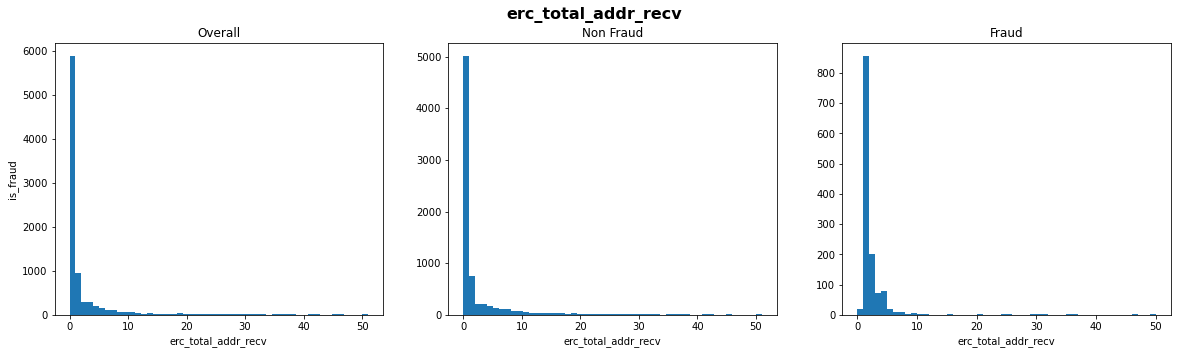

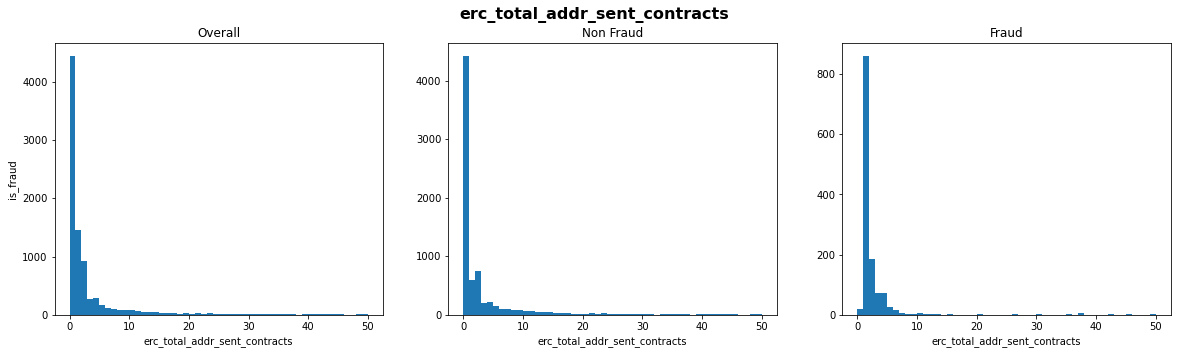

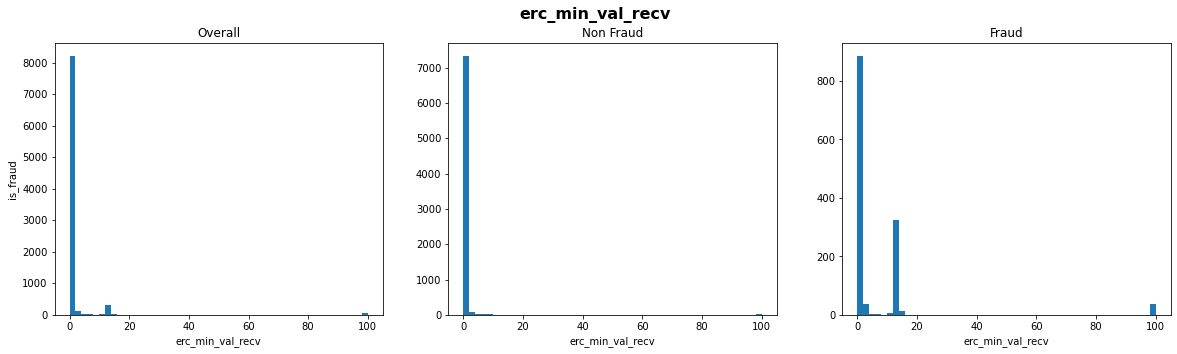

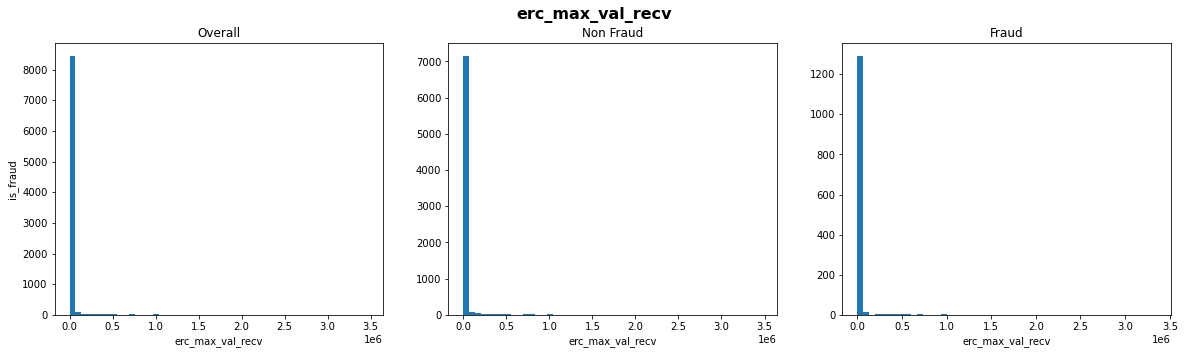

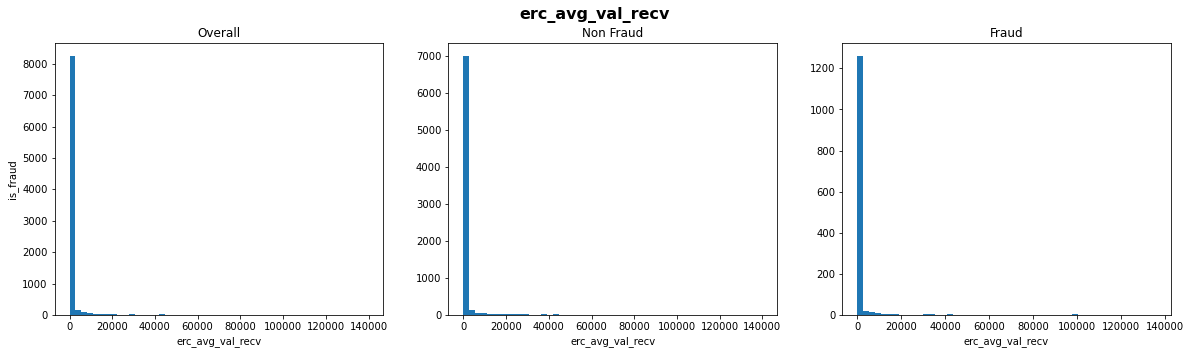

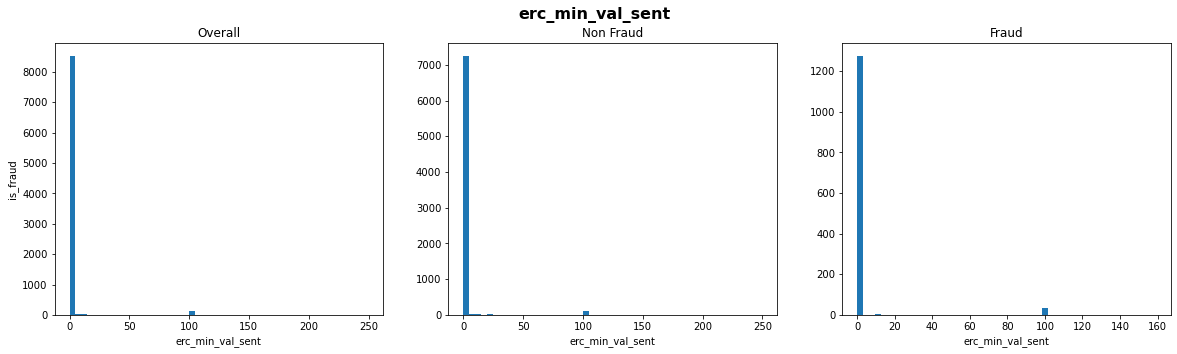

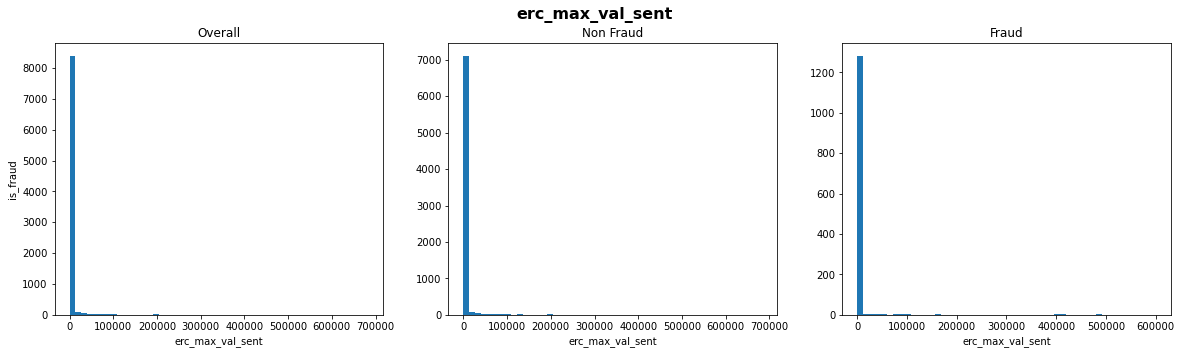

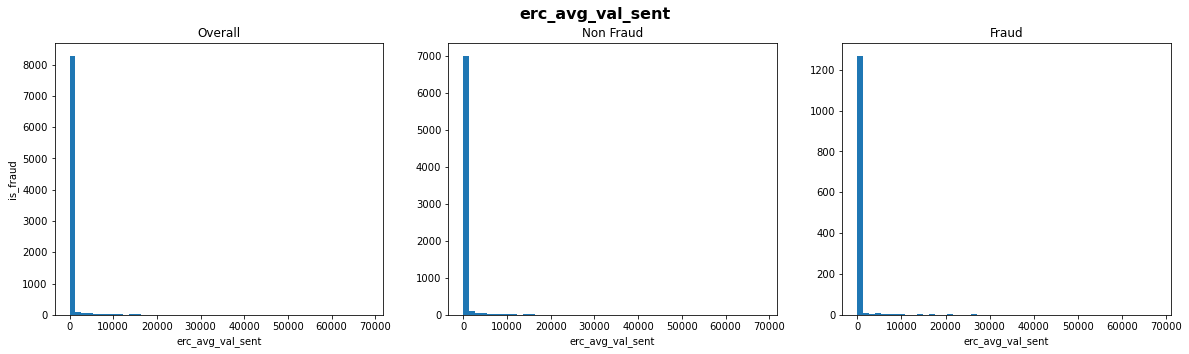

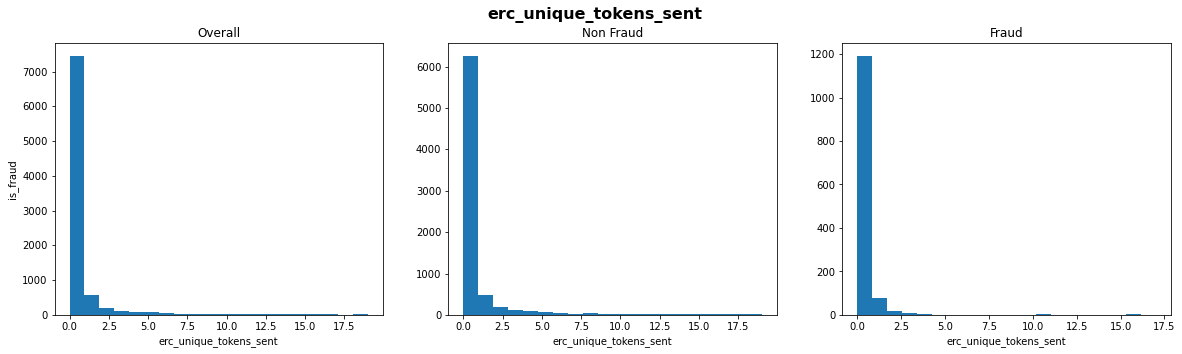

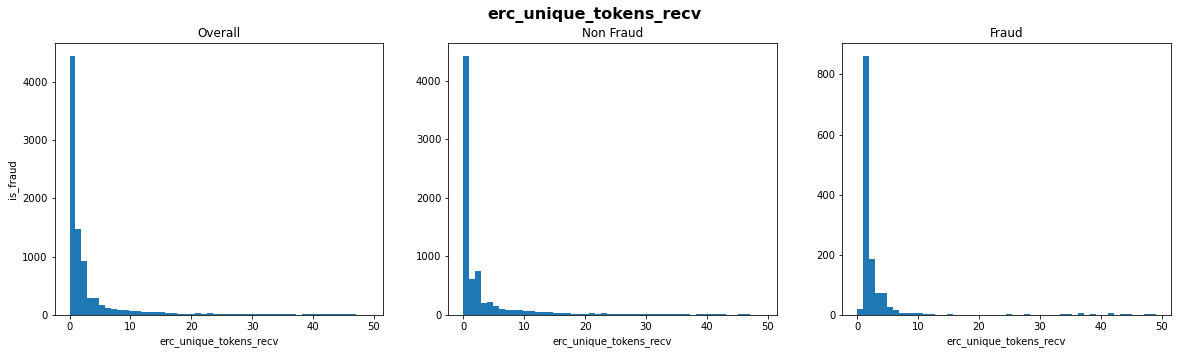

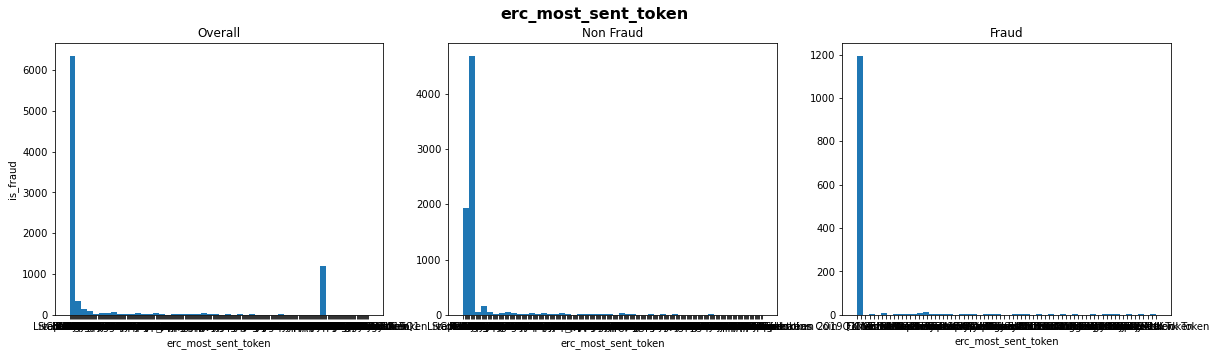

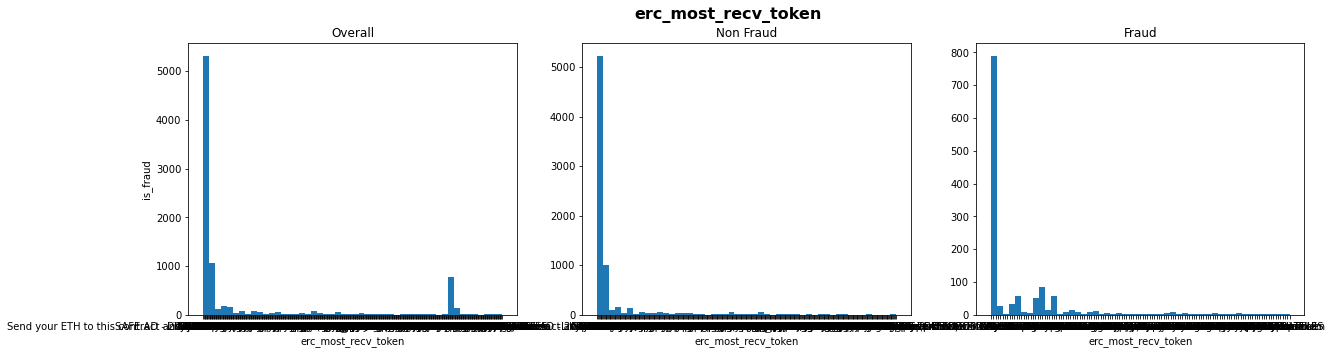

In [17]:
for i in cols:
    compare_plot(df_erc, 'is_fraud', i)

## Cleaning & Feature Engineering

In [18]:
df1 = df.copy()
df1 = df1[df1['erc_ether_recv'].notna()]

df1['equal_min_max_recv']= df1.apply(lambda x: 1 if (x['min_val_recv'] == x['max_val_recv']) else 0,axis=1)
df1['equal_min_max_sent']= df1.apply(lambda x: 1 if (x['min_val_sent'] == x['max_val_sent']) else 0,axis=1)
df1['equal_min_max_sent_contracts']= df1.apply(lambda x: 1 if (x['min_val_sent_contracts'] == x['max_val_sent_contracts']) else 0,axis=1)

df1['total_ether_token_recv_ratio'] = df1['erc_ether_recv']/df1['total_ether_recv']
df1['total_ether_token_sent_ratio'] = df1['erc_ether_sent']/df1['total_ether_sent']
df1['avg_ether_token_recv_ratio'] = df1['erc_avg_val_recv']/df1['avg_val_recv']
df1['avg_ether_token_sent_ratio'] = df1['erc_avg_val_sent']/df1['avg_val_sent']

df1['total_ether_token_recv_ratio'] = df1['total_ether_token_recv_ratio'].replace([np.inf, -np.inf], -1)
df1['total_ether_token_sent_ratio'] = df1['total_ether_token_sent_ratio'].replace([np.inf, -np.inf], -1)
df1['avg_ether_token_recv_ratio'] = df1['avg_ether_token_recv_ratio'].replace([np.inf, -np.inf], -1)
df1['avg_ether_token_sent_ratio'] = df1['avg_ether_token_sent_ratio'].replace([np.inf, -np.inf], -1)

df1['total_ether_token_recv_ratio'] = df1['total_ether_token_recv_ratio'].replace(-1, max(df1['total_ether_token_recv_ratio'])).fillna(0)
df1['total_ether_token_sent_ratio'] = df1['total_ether_token_sent_ratio'].replace(-1, max(df1['total_ether_token_sent_ratio'])).fillna(0)
df1['avg_ether_token_recv_ratio'] = df1['avg_ether_token_recv_ratio'].replace(-1, max(df1['avg_ether_token_recv_ratio'])).fillna(0)
df1['avg_ether_token_sent_ratio'] = df1['avg_ether_token_sent_ratio'].replace(-1, max(df1['avg_ether_token_sent_ratio'])).fillna(0)

df1 = df1.drop(['min_val_recv','min_val_sent','min_val_sent_contracts'],axis=1)

In [19]:
df2 = df1.copy()

df2['erc_sent_contract'] = df2['erc_ether_sent_contracts'].apply(lambda x: 0 if x==0 else 1)
df2['erc_max_avg_val_recv'] = df2['erc_max_val_recv']/df2['erc_avg_val_recv']
df2['erc_max_avg_val_recv'] = df2['erc_max_avg_val_recv'].fillna(1)

df2['erc_max_avg_val_sent'] = df2['erc_max_val_sent']/df['erc_avg_val_sent']
df2['erc_max_avg_val_sent'] = df2['erc_max_avg_val_sent'].fillna(1)

df2['erc_max_avg_val_recv'] = df2['erc_max_avg_val_recv'].replace([np.inf, -np.inf], -1)
df2['erc_max_avg_val_recv'] = df2['erc_max_avg_val_recv'].replace(-1, max(df2['erc_max_avg_val_recv']))

df2['erc_max_avg_val_sent'] = df2['erc_max_avg_val_sent'].replace([np.inf, -np.inf], -1)
df2['erc_max_avg_val_sent'] = df2['erc_max_avg_val_sent'].replace(-1, max(df2['erc_max_avg_val_sent']))

df2['erc_most_recv_token'] = df2['erc_most_recv_token'].replace({'0': None,
                                                                 ' ': None,
                                                                 "''": None,
                                                                 '\x01': None,})

df2['erc_most_sent_token'] = df2['erc_most_sent_token'].replace({'0': None,
                                                                 ' ': None,
                                                                 "''": None,
                                                                 '\x01': None,})

df3 = df2.drop(['erc_min_val_sent','erc_ether_sent_contracts'], axis=1)

In [20]:
most_sent_fraud_ratio = df3.groupby(['erc_most_sent_token'])['is_fraud']\
                           .mean()\
                           .reset_index()\
                           .rename(columns={'is_fraud':'erc_most_sent_token_fraud'})
            
most_recv_fraud_ratio = df3.groupby(['erc_most_recv_token'])['is_fraud']\
                           .mean()\
                           .reset_index()\
                           .rename(columns={'is_fraud':'erc_most_recv_token_fraud'})

df4 = df3.merge(most_sent_fraud_ratio, on='erc_most_sent_token', how="left")
df4 = df4.merge(most_recv_fraud_ratio, on='erc_most_recv_token', how="left")

df4['erc_most_sent_token_fraud'] = df4['erc_most_sent_token_fraud'].fillna(0)
df4['erc_most_recv_token_fraud'] = df4['erc_most_recv_token_fraud'].fillna(0)

df4 = df4.drop(['erc_most_sent_token','erc_most_recv_token'], axis=1)

In [21]:
pd.concat([df4.isna().sum(),df4.nunique()],axis=1).rename(columns = {0:'Nulls',1:'Uniques'})

,Nulls,Uniques
is_fraud,0,2
avg_time_between_sends,0,4831
avg_time_between_recvs,0,5825
time_since_first_transaction,0,7287
sent_transactions,0,641
recv_transactions,0,726
num_created_contracts,0,20
total_addr_recv,0,252
total_addr_sent,0,258
max_val_recv,0,6111


## Resampling

80-20 train test split

train set is resampled, cross validated and used for modelling

test set is for evaluating model performance

In [117]:
X = df4.drop(['is_fraud'], axis=1)
y = df4['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

In [118]:
smt = SMOTEENN(random_state=0, n_jobs=-1)
X_smt, y_smt = smt.fit_resample(X_train, y_train)

In [119]:
pd.concat([y_train.value_counts().rename('original'), y_smt.value_counts().rename('smoteenn')], axis=1)

,original,smoteenn
0,6115,5025
1,1094,5384


## Modelling

In [120]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [121]:
rfc = RandomForestClassifier(max_features='sqrt', min_samples_leaf=1, min_samples_split=2,
                             bootstrap=False, n_estimators = 360)

Random Forest Accuracy: 0.99779


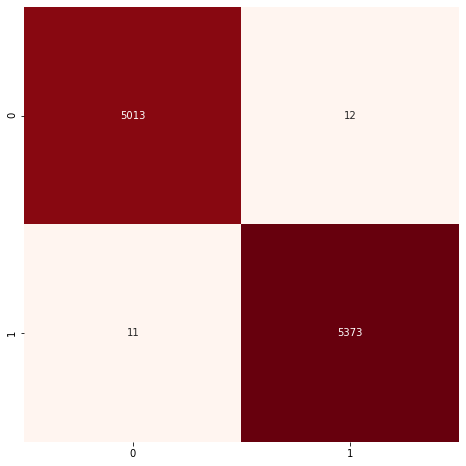

In [122]:
y_pred_rfc = cross_val_predict(rfc, X_smt, y_smt, n_jobs=-1, cv=skf)

print(f'Random Forest Accuracy: ' + str(accuracy_score(y_smt, y_pred_rfc).round(5)))

matrix_confusion = confusion_matrix(y_smt, y_pred_rfc)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Reds', fmt='d', cbar=False)
fig=plt.gcf()
fig.set_size_inches(8,8)
plt.show()

In [123]:
xgc = xgb.XGBClassifier(booster='gbtree', tree_method='hist', colsample_bytree=0.95,
                        learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=240, n_jobs=-1,
                        objective='multi:softmax', reg_alpha=0, reg_lambda=2, scale_pos_weight=1, num_class=2)

XGBoost Accuracy: 0.9976


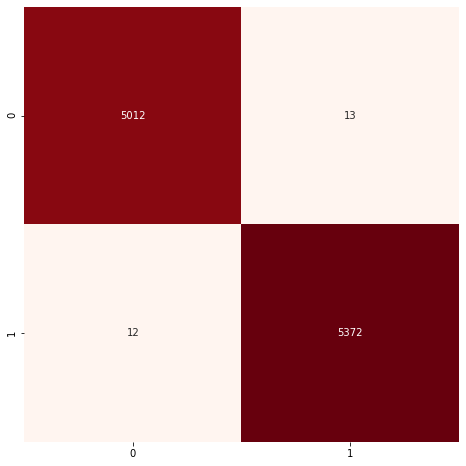

In [124]:
y_pred_xgc = cross_val_predict(xgc, X_smt, y_smt, n_jobs=-1, cv=skf)

print(f'XGBoost Accuracy: ' + str(accuracy_score(y_smt, y_pred_xgc).round(5)))

matrix_confusion = confusion_matrix(y_smt, y_pred_xgc)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Reds', fmt='d', cbar=False)
fig=plt.gcf()
fig.set_size_inches(8,8)
plt.show()

In [160]:
dtc = DecisionTreeClassifier(max_depth=8,criterion='entropy',max_features=19,splitter='best')
abc = AdaBoostClassifier(base_estimator = dtc, n_estimators=200, learning_rate=1)

AdaBoost Accuracy: 0.99885


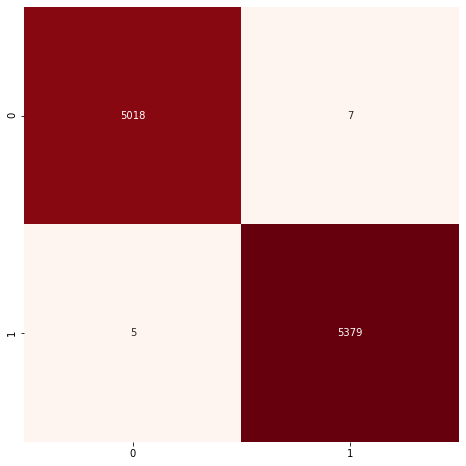

In [161]:
y_pred_abc = cross_val_predict(abc, X_smt, y_smt, n_jobs=-1, cv=skf)

print(f'AdaBoost Accuracy: ' + str(accuracy_score(y_smt, y_pred_abc).round(5)))

matrix_confusion = confusion_matrix(y_smt, y_pred_abc)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Reds', fmt='d', cbar=False)
fig=plt.gcf()
fig.set_size_inches(8,8)
plt.show()

In [162]:
matrix_confusion = confusion_matrix(y_smt, y_pred_abc)
precision, recall, fscore, support = precision_recall_fscore_support(y_smt, y_pred_abc, average='macro')
fpr, tpr, threshold = roc_curve(y_smt, y_pred_abc)
roc_auc = auc(fpr, tpr)
print(f'Accuracy : {accuracy_score(y_smt, y_pred_abc).round(5)}')
print(f'Precision: {precision.round(5)}')
print(f'Recall   : {recall.round(5)}')
print(f'F-score  : {fscore.round(5)}')
print(f'ROC AUC  : {roc_auc.round(5)}')

Accuracy : 0.99885
Precision: 0.99885
Recall   : 0.99884
F-score  : 0.99885
ROC AUC  : 0.99884


In [159]:
results = pd.DataFrame({'actual': y_smt, 'rfc': y_pred_rfc, 'xgc': y_pred_xgc, 'abc': y_pred_abc})

## Final Model

In [128]:
dtc = DecisionTreeClassifier(max_depth=8,criterion='entropy',max_features=19,splitter='best')
abc = AdaBoostClassifier(base_estimator = dtc, n_estimators=200, learning_rate=1)

In [129]:
abc_fit = abc.fit(X_train, y_train)
y_pred = abc_fit.predict(X_test)

In [130]:
matrix_confusion = confusion_matrix(y_test, y_pred)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

Accuracy : 0.99445
Precision: 0.99342
Recall   : 0.98373
F-score  : 0.98851
ROC AUC  : 0.98373


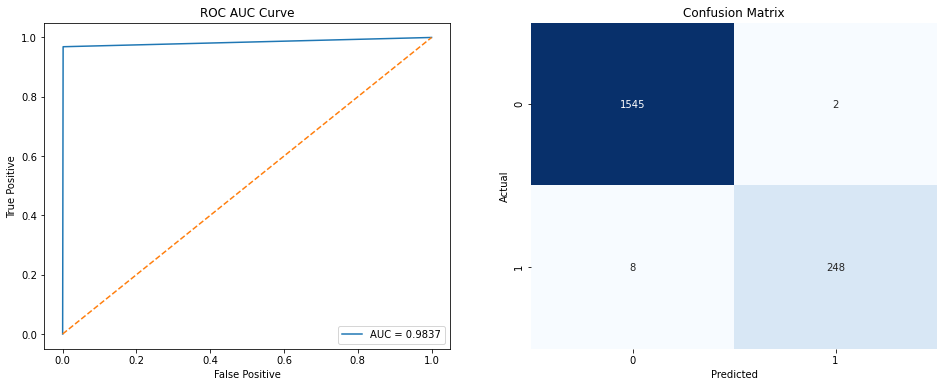

In [66]:
print(f'Accuracy : {accuracy_score(y_test, y_pred).round(5)}')
print(f'Precision: {precision.round(5)}')
print(f'Recall   : {recall.round(5)}')
print(f'F-score  : {fscore.round(5)}')
print(f'ROC AUC  : {roc_auc.round(5)}')

fig, axes = plt.subplots(1, 2)

sns.lineplot(fpr, tpr, label='AUC = %0.4f'%roc_auc, ax=axes[0])
sns.lineplot([0, 1], [0, 1], ax=axes[0])
axes[0].lines[1].set_linestyle("--")
axes[0].set(xlabel='False Positive', ylabel='True Positive')
axes[0].set_title('ROC AUC Curve')

sns.heatmap(matrix_confusion, square=False, annot=True, cmap='Blues', fmt='d', cbar=False, ax=axes[1])
axes[1].set(xlabel='Predicted', ylabel='Actual')
axes[1].set_title('Confusion Matrix')

fig=plt.gcf()
fig.set_size_inches(16,6)
plt.show()

## Feature Importance

In [132]:
rfc_fit = rfc.fit(X_train, y_train)

importance = rfc_fit.feature_importances_
std = np.std([rfc_fit.feature_importances_ for tree in rfc_fit.estimators_], axis=0)

data={'feature_names':X_train.columns,'feature_importance':importance,'standard_deviation':std}
fi_df = pd.DataFrame(data)

fi_df = fi_df.sort_values(by=['feature_importance'], ascending=False)

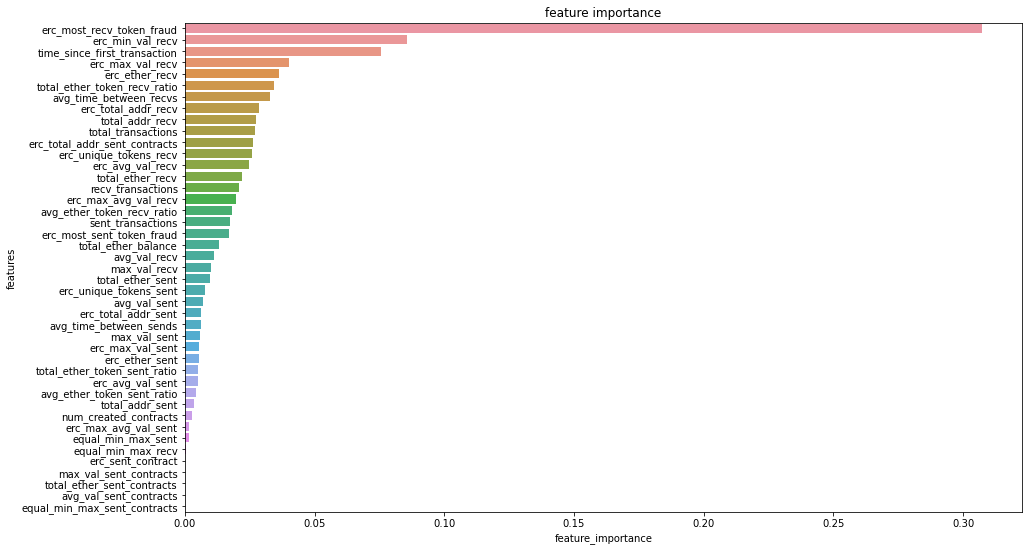

In [133]:
plt.figure(figsize=(15,9))
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
plt.title('feature importance')
plt.ylabel('features')
plt.show()

## Ensembling

Tried it out and doesn't really improve result but I decided to keep it in.

In [134]:
%%time

names = ['rfc','xgc','abc']
classifiers = [rfc,xgc,abc]

clfs = list(zip(names, classifiers))

soft = VotingClassifier(estimators=clfs, voting='soft', verbose=True)
hard = VotingClassifier(estimators=clfs, voting='hard', verbose=True)

soft.fit(X_smt, y_smt)
hard.fit(X_smt, y_smt)

y_soft = soft.predict(X_test)
y_hard = hard.predict(X_test)

[Voting] ...................... (1 of 3) Processing rfc, total=   5.8s
[01:11:02] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:11:02] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[Voting] ...................... (2 of 3) Processing xgc, total=   1.0s
[Voting] ...................... (3 of 3) Processing 

In [135]:
print(f'Soft Vote Accuracy: ' + str(accuracy_score(y_test, y_soft).round(5)))

Soft Vote Accuracy: 0.99279


In [136]:
print(f'Hard Vote Accuracy: ' + str(accuracy_score(y_test, y_hard).round(5)))

Hard Vote Accuracy: 0.99334
